![ieseg logo](./img/ieseg.png)

#### MBD 2019-2020 - Stephanie Beyer Diaz
# Statistical & Machine Learning Approaches for Marketing

## Section 1: Introduction & Linear Regression

**1. Import all required libraries and datasets**

In [2]:
# Set environment params
Sys.setenv(LANG='en')  # English

# Import libraries
library(data.table)  # Data manipulate
library(mlr)         # ML toolkit
library(caret)       # ML toolkit
library(ggplot2)     # Visualization

# Import data
library(ISLR)      # Data from the course book
library(MASS)      # Boston housing dataset
library(datasets)  # US crime dataset

# Resize plot
library(repr)  # String and binary representations
#options(repr.plot.width=4, repr.plot.height=4)

R.version.string

Warning message:
"package 'mlr' was built under R version 3.6.2"Loading required package: ParamHelpers
Warning message:
"package 'ParamHelpers' was built under R version 3.6.2"'mlr' is in maintenance mode since July 2019. Future development
efforts will go into its successor 'mlr3' (<https://mlr3.mlr-org.com>).
Warning message:
"package 'caret' was built under R version 3.6.2"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.6.2"Loading required package: ggplot2

Attaching package: 'caret'

The following object is masked from 'package:mlr':

    train

Warning message:
"package 'ISLR' was built under R version 3.6.2"Warning message:
"package 'MASS' was built under R version 3.6.2"

[1] "R version 3.6.1 (2019-07-05)"

In [3]:
# Install missing packages
# install.packages("ISLR")

**2. Simulate Bias-Variance trade-off**  

Source: https://daviddalpiaz.github.io/r4sl/biasvariance-tradeoff.html

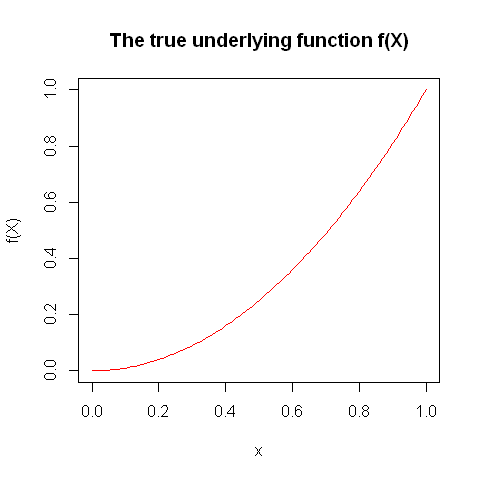

In [4]:
# The true underlying function
f <- function(x) {
  x ^ 2
}

# Plot the underlying function
options(repr.plot.width=4, repr.plot.height=4)  # Set plot size
op <- par(cex = 0.8)  # Set font size

plot(f, type='l', col='red',
     main="The true underlying function f(X)",
     ylab="f(X)", xlab="x")

In [5]:
# Function to generate simulation data from true function f
get_sim_data <- function(f, sample_size=100) {
  x <- runif(n=sample_size, min=0, max=1)  # Generate a list of x values
  eps <- rnorm(n=sample_size, mean=0, sd=0.75)  # Generate random errors
  y <- f(x) + eps
  data.frame(x, y)
}

In [6]:
# Generate simulation data
set.seed(1)
n_sims <- 250  # Number of simulations
n_models <- 4  # Number of models
x <- data.frame(x=0.90)  # Fixed point at which we make predictions [test]
predictions <- matrix(0, nrow=n_sims, ncol=n_models)  # Blank matrix

In [7]:
# Run the simulation
for (sim in 1:n_sims) {
  # Simulate new, random, training data
  sim_data <- get_sim_data(f)

  # Fit different models
  fit_0 <- lm(y ~ 1,                 data=sim_data)  # Simple linear regression
  fit_1 <- lm(y ~ poly(x, degree=1), data=sim_data)  # Polynomial regression (degree = 1)
  fit_2 <- lm(y ~ poly(x, degree=2), data=sim_data)  # Polynomial regression (degree = 2)
  fit_9 <- lm(y ~ poly(x, degree=9), data=sim_data)  # Polynomial regression (degree = 9)

  # Get predictions
  predictions[sim, 1] <- predict(fit_0, x)
  predictions[sim, 2] <- predict(fit_1, x)
  predictions[sim, 3] <- predict(fit_2, x)
  predictions[sim, 4] <- predict(fit_9, x)
}

In [8]:
# Prediction results of 4 models
head(predictions)

0.3258666,0.8026078,0.8740580,0.8400974
0.3584500,0.8086247,0.9290869,0.9553229
0.2988305,0.8882596,1.0523587,1.0652415
0.2934798,0.6446183,0.6913260,0.6451949
0.2466116,0.6604834,0.7793907,0.7260935
0.3835104,0.6651398,0.6850260,0.5974535


In [9]:
# Function to calculate mse, bias, variance
get_mse <- function(truth, estimate) {
  mean((estimate - truth) ^ 2)
}

get_bias <- function(estimate, truth) {
  mean(estimate) - truth
}

get_var <- function(estimate) {
  mean((estimate - mean(estimate)) ^ 2)
}

In [10]:
# Run the simulate
bias <- apply(predictions, 2, get_bias, truth=f(x=0.90))
variance <- apply(predictions, 2, get_var)
mse <- apply(predictions, 2, get_mse, truth=f(x=0.90))

In [11]:
# Prepare the data for plotting
bvto <- data.frame(degree=c(0, 1, 2, 9), mse=mse, bias_squared=bias^2, variance=variance)
bvto

degree,mse,bias_squared,variance
0,0.23093518,0.2249205068,0.006014669
1,0.02248629,0.0041071112,0.018379178
2,0.02417563,0.0003348458,0.023840782
9,0.06371456,0.0001312804,0.063583280


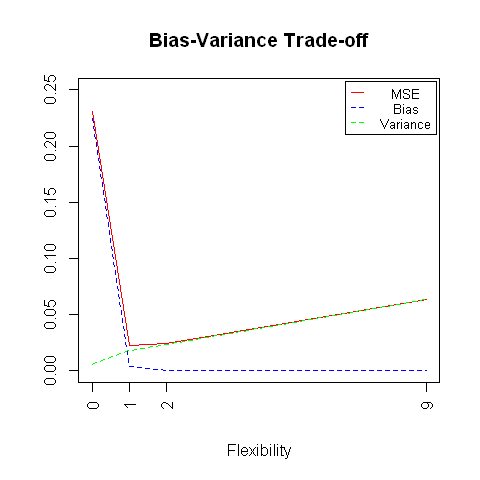

In [12]:
# Plot the Bias-Variance Trade-off
options(repr.plot.width=4, repr.plot.height=4)  # Set plot size
op <- par(cex = 0.8)  # Set font size

plot(bvto$degree, bvto$mse, type='l', col='red', ylim=c(0, 0.25),
     main="Bias-Variance Trade-off",
     ylab="", xlab="Flexibility",
     xaxt="n")  # MSE
lines(bvto$degree, bvto$bias_squared, col='blue', type="l", lty=2)  # Bias
lines(bvto$degree, bvto$variance, col='green', type="l", lty=2)  # Variance

op <- par(cex = 0.8)  # Set font size
axis(side=1, at=c(0, 1, 2, 9), las=2)  # Add x tickers
legend("topright", legend=c("MSE", "Bias", "Variance"),
       col=c("red", "blue", "green"), lty=c(1, 2, 2), cex=0.8,
       x.intersp=7, y.intersp=2, adj=0.5, inset=0.01)

**3. Simple Linear Regression**

In [13]:
# Import Advertising data
adv <- read.csv('./data/Advertising.csv', row.names=1)
head(adv)

TV,radio,newspaper,sales
230.1,37.8,69.2,22.1
44.5,39.3,45.1,10.4
17.2,45.9,69.3,9.3
151.5,41.3,58.5,18.5
180.8,10.8,58.4,12.9
8.7,48.9,75.0,7.2


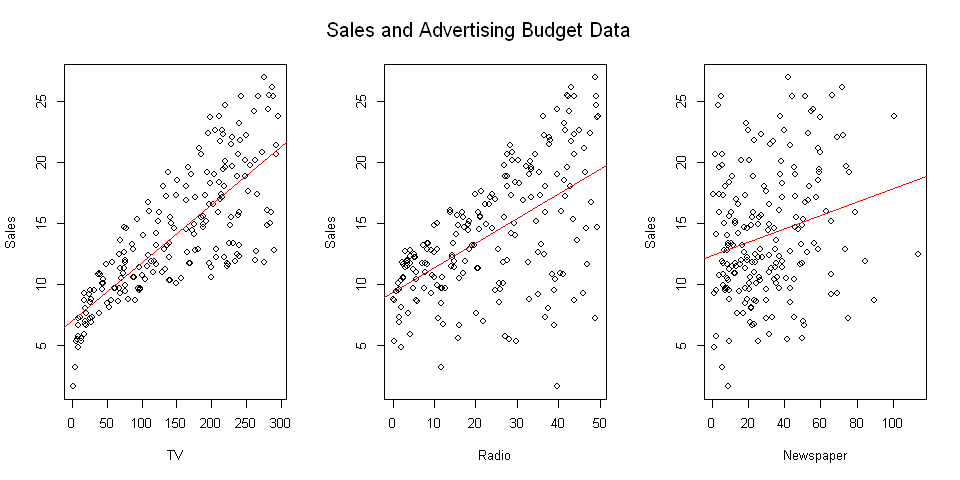

In [14]:
# Plot the data
options(repr.plot.width=8, repr.plot.height=4)  # Set plot size
par(mfrow=c(1, 3))  # Set the plot regions

plot(adv$TV, adv$sales, ylab="Sales", xlab="TV")
abline(lm(sales ~ TV, data=adv), col='red')

plot(adv$radio, adv$sales, ylab="Sales", xlab="Radio")
abline(lm(sales ~ radio, data=adv), col='red')

plot(adv$newspaper, adv$sales, ylab="Sales", xlab="Newspaper")
abline(lm(sales ~ newspaper, data=adv), col='red')

mtext("Sales and Advertising Budget Data", side=3, line=-2.5, outer=TRUE)

**Estimation of the parameters by least squares**

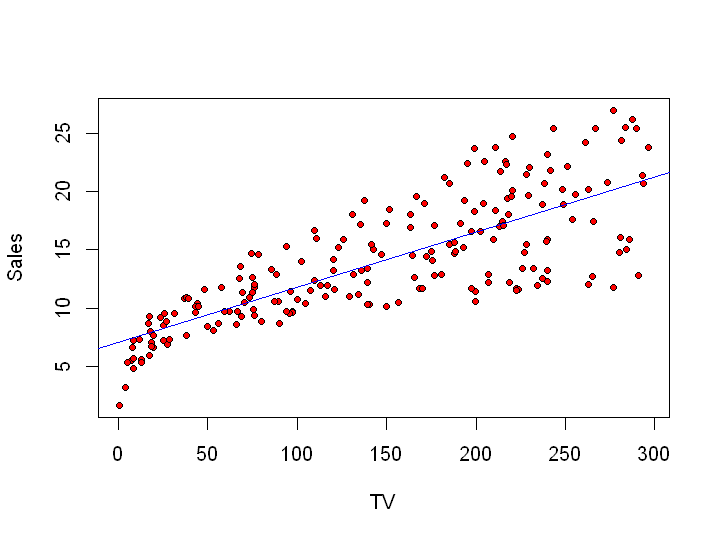

In [15]:
# Plot Sales ~ TV
options(repr.plot.width=6, repr.plot.height=4.5)  # Set plot size

plot(adv$TV, adv$sales, pch=21, cex=0.8, bg='red',
     xlab='TV', ylab='Sales')
abline(lm(sales ~ TV, data=adv), col='blue')

**Exercise 1:** Calculate B0, B1 for Sales ~ f(TV)

In [16]:
avg_x <- mean(adv$TV)
avg_y <- mean(adv$sales)

B1 <- sum((adv$TV-avg_x)*(adv$sales-avg_y))/sum((adv$TV-avg_x)^2)
B0 <- avg_y - B1 * avg_x

print(B0)
print(B1)

[1] 7.032594
[1] 0.04753664


In [17]:
# Check B0, B1 by lm function
md <- lm(sales ~ TV, data=adv)
summary(md)


Call:
lm(formula = sales ~ TV, data = adv)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.3860 -1.9545 -0.1913  2.0671  7.2124 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.032594   0.457843   15.36   <2e-16 ***
TV          0.047537   0.002691   17.67   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.259 on 198 degrees of freedom
Multiple R-squared:  0.6119,	Adjusted R-squared:  0.6099 
F-statistic: 312.1 on 1 and 198 DF,  p-value: < 2.2e-16


**Exercise 2:** Calculate B0, B1 for Sales ~ f(Radio)

In [18]:
avg_radio <-  mean(adv$radio)

#using avg_y from Exercise 1
B1_2 <- sum((adv$radio-avg_radio)*(adv$sales-avg_y))/sum((adv$radio-avg_radio)^2)
B0_2 <- avg_y - B1_2 * avg_radio 

print(B0_2)
print(B1_2)

[1] 9.311638
[1] 0.2024958


In [19]:
# Check B0, B1 by lm function
summary(lm(sales ~ radio, data=adv))


Call:
lm(formula = sales ~ radio, data = adv)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.7305  -2.1324   0.7707   2.7775   8.1810 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.31164    0.56290  16.542   <2e-16 ***
radio        0.20250    0.02041   9.921   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.275 on 198 degrees of freedom
Multiple R-squared:  0.332,	Adjusted R-squared:  0.3287 
F-statistic: 98.42 on 1 and 198 DF,  p-value: < 2.2e-16


**Exercise 3:** Calculate the 95% confidence interval of B0, B1 for model Sales ~ f(TV)?

In [20]:
#using: β1 ± 2 · SE(β1)
md <- lm(sales ~ TV, data=adv)
SE <- summary(md)$coefficients[,2]

print(paste("Confidence Interval for B0: [",B0 - 2*SE[1],",",B0 + 2*SE[1],"]"))
print(paste("Confidence Interval for B1: [",B1 - 2*SE[2],",",B1 + 2*SE[2],"]"))

                     
#Manual SE calculation:
n <- nrow(adv)
RSS <- sum((adv$sales-md$fitted.values)^2) #same as sum((adv$sales - B0 - B1*adv$TV)**2)
RSE <- sqrt(RSS/(n-2))
avg_tv <- mean(adv$TV)
SE_2 <- sqrt(RSE^2*(1/n + (avg_tv^2)/sum((adv$TV - avg_tv)^2)))
SE_2[2] <- sqrt(RSE^2/sum((adv$TV - avg_tv)^2))

print(paste("Manual CI for B0: [",B0 - 2*SE_2[1],",",B0 + 2*SE_2[1],"]"))
print(paste("Manual CI for B1: [",B1 - 2*SE_2[2],",",B1 + 2*SE_2[2],"]"))


[1] "Confidence Interval for B0: [ 6.11690766858074 , 7.94827942967465 ]"
[1] "Confidence Interval for B1: [ 0.042155426057426 , 0.0529178548086135 ]"
[1] "Manual CI for B0: [ 6.11690766858074 , 7.94827942967465 ]"
[1] "Manual CI for B1: [ 0.042155426057426 , 0.0529178548086135 ]"


In [21]:
# Double check with the lm function
md <- lm(sales ~ TV, data=adv)
summary(md)


Call:
lm(formula = sales ~ TV, data = adv)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.3860 -1.9545 -0.1913  2.0671  7.2124 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.032594   0.457843   15.36   <2e-16 ***
TV          0.047537   0.002691   17.67   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.259 on 198 degrees of freedom
Multiple R-squared:  0.6119,	Adjusted R-squared:  0.6099 
F-statistic: 312.1 on 1 and 198 DF,  p-value: < 2.2e-16


**Exercise 4:** Calculate the t-statistic and p-value for predictors radio and newspaper.

Calculate t-statistic for Sales ~ f(Radio)

In [22]:
# Show the model of Sales ~ f(Radio)
md <- lm(sales ~ radio, data=adv)
summary(md)


Call:
lm(formula = sales ~ radio, data = adv)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.7305  -2.1324   0.7707   2.7775   8.1810 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.31164    0.56290  16.542   <2e-16 ***
radio        0.20250    0.02041   9.921   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.275 on 198 degrees of freedom
Multiple R-squared:  0.332,	Adjusted R-squared:  0.3287 
F-statistic: 98.42 on 1 and 198 DF,  p-value: < 2.2e-16


In [23]:
md <- lm(sales ~ radio, data=adv)

#t: (B1-0)/SE
#Manual SE calculation: using B values from exercise 2
n <- nrow(adv)
fitted <- (adv$sales - B0_2 - B1_2*adv$radio)**2
RSS <- sum(fitted)
RSE <- sqrt(RSS/(n-2))

SE_m <- sqrt(RSE^2*(1/n + (avg_radio^2)/sum((adv$radio - avg_radio)^2)))
SE_m[2] <- sqrt(RSE^2/sum((adv$radio - avg_radio)^2))

# #using B values from exercise 2
t_B0 <- B0_2/SE_m[1]
t_B1 <- B1_2/SE_m[2]

print(paste("B0 t-statistic:",t_B0))
print(paste("B1 t-statistic:",t_B1))

[1] "B0 t-statistic: 16.5422453112582"
[1] "B1 t-statistic: 9.92076547282496"


Calculate t-statistic for Sales ~ f(Newspaper)

In [24]:
# Show the model of Sales ~ f(Newspaper)
md_np <- lm(sales ~ newspaper, data=adv)
summary(md_np)


Call:
lm(formula = sales ~ newspaper, data = adv)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.2272  -3.3873  -0.8392   3.5059  12.7751 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12.35141    0.62142   19.88  < 2e-16 ***
newspaper    0.05469    0.01658    3.30  0.00115 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.092 on 198 degrees of freedom
Multiple R-squared:  0.05212,	Adjusted R-squared:  0.04733 
F-statistic: 10.89 on 1 and 198 DF,  p-value: 0.001148


In [25]:
avg_np <-  mean(adv$newspaper)

#using avg_y from Exercise 1
B1_n <- sum((adv$newspaper-avg_np)*(adv$sales-avg_y))/sum((adv$newspaper-avg_np)^2)
B0_n <- avg_y - B1_n * avg_np

n <- nrow(adv)
fitted <- (adv$sales - B0_n - B1_n*adv$newspaper)**2
RSS <- sum(fitted)
RSE <- sqrt(RSS/(n-2))

SE_n <- sqrt(RSE^2*(1/n + (avg_np^2)/sum((adv$newspaper - avg_np)^2)))
SE_n[2] <- sqrt(RSE^2/sum((adv$newspaper - avg_np)^2))

t_B0n <- B0_n/SE_n[1]
t_B1n <- B1_n/SE_n[2]

print(paste("B0 t-statistic:",t_B0n))
print(paste("B1 t-statistic:",t_B1n))

[1] "B0 t-statistic: 19.8760956202489"
[1] "B1 t-statistic: 3.29959074363342"


**Exercise 5:** Calculate the RSE and R-squared for predictors radio and newspaper.

Calculate the RSE and R-squared for Sales ~ f(Radio)

In [26]:
# Show the model of Sales ~ f(Radio)
md <- lm(sales ~ radio, data=adv)
summary(md)


Call:
lm(formula = sales ~ radio, data = adv)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.7305  -2.1324   0.7707   2.7775   8.1810 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.31164    0.56290  16.542   <2e-16 ***
radio        0.20250    0.02041   9.921   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.275 on 198 degrees of freedom
Multiple R-squared:  0.332,	Adjusted R-squared:  0.3287 
F-statistic: 98.42 on 1 and 198 DF,  p-value: < 2.2e-16


In [27]:
#RSE: sqrt(1/(n-2)*sum(yi-ypred)^2)
n <- nrow(adv)
rse <- sqrt(sum((adv$sales-md$fitted.values)^2)/(n-2))

#R2: 
rss <- rse^2*(n-2)
tss <- sum((adv$sales-avg_y)^2)
r2 <- 1 - rss/tss

cat(paste("RSE:",rse,"\nR2:",r2))

RSE: 4.27494435490106 
R2: 0.332032455445295

Calculate the RSE and R-squared for Sales ~ f(Newspaper)

In [28]:
# Show the model of Sales ~ f(Newspaper)
md <- lm(sales ~ newspaper, data=adv)
summary(md)


Call:
lm(formula = sales ~ newspaper, data = adv)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.2272  -3.3873  -0.8392   3.5059  12.7751 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12.35141    0.62142   19.88  < 2e-16 ***
newspaper    0.05469    0.01658    3.30  0.00115 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.092 on 198 degrees of freedom
Multiple R-squared:  0.05212,	Adjusted R-squared:  0.04733 
F-statistic: 10.89 on 1 and 198 DF,  p-value: 0.001148


In [29]:
#RSE: sqrt(1/(n-2)*sum(yi-ypred)^2)
n <- nrow(adv)
rse <- sqrt(sum((adv$sales-md$fitted.values)^2)/(n-2))

#R2: 
rss <- rse^2*(n-2)
tss <- sum((adv$sales-avg_y)^2)
r2 <- 1 - rss/tss

cat(paste("RSE:",rse,"\nR2:",r2))

RSE: 5.09248036652019 
R2: 0.0521204454443052

**4. Multiple Linear Regression**

In [30]:
# Import Advertising data
adv <- read.csv('./data/Advertising.csv', row.names=1)
head(adv)
str(adv)

TV,radio,newspaper,sales
230.1,37.8,69.2,22.1
44.5,39.3,45.1,10.4
17.2,45.9,69.3,9.3
151.5,41.3,58.5,18.5
180.8,10.8,58.4,12.9
8.7,48.9,75.0,7.2


'data.frame':	200 obs. of  4 variables:
 $ TV       : num  230.1 44.5 17.2 151.5 180.8 ...
 $ radio    : num  37.8 39.3 45.9 41.3 10.8 48.9 32.8 19.6 2.1 2.6 ...
 $ newspaper: num  69.2 45.1 69.3 58.5 58.4 75 23.5 11.6 1 21.2 ...
 $ sales    : num  22.1 10.4 9.3 18.5 12.9 7.2 11.8 13.2 4.8 10.6 ...


**Exercise 6:** Use the matrix formula to estimate the parameters of multilinear regression model.

In [31]:
y <- as.matrix(adv$sales)
x <- as.matrix(cbind(1,adv[,1:3]))

In [32]:
#solve: inverse matrix
solve(t(x) %*% x) %*% t(x) %*% y

1,2.938889369
TV,0.045764645
radio,0.188530017
newspaper,-0.001037493


In [33]:
# Compare with the function of R
md <- lm(sales ~ ., data=adv)
summary(md)


Call:
lm(formula = sales ~ ., data = adv)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.8277 -0.8908  0.2418  1.1893  2.8292 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.938889   0.311908   9.422   <2e-16 ***
TV           0.045765   0.001395  32.809   <2e-16 ***
radio        0.188530   0.008611  21.893   <2e-16 ***
newspaper   -0.001037   0.005871  -0.177     0.86    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.686 on 196 degrees of freedom
Multiple R-squared:  0.8972,	Adjusted R-squared:  0.8956 
F-statistic: 570.3 on 3 and 196 DF,  p-value: < 2.2e-16


## Lab: 

1. Construct your own Multiple Linear Regression model on Credit data.

2. Linear Regression with Interactions term on Advertising data.

3. Polynomial regression on Auto data.

**1. Construct your own Multiple Linear Regression model on Credit data: Predict customer balance**

In [34]:
# Import data
credit <- read.csv('./data/Credit.csv', row.names=1)
head(credit)

Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
104.593,7075,514,4,71,11,Male,No,No,Asian,580
148.924,9504,681,3,36,11,Female,No,No,Asian,964
55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
80.180,8047,569,4,77,10,Male,No,No,Caucasian,1151


Using the matrix formula to manually estimate the multiple linear regression model with 3 predictors Age, Rating, Limit.

In [35]:
y <- as.matrix(credit$Balance)
x <- as.matrix(cbind(1,credit[,c("Age","Rating","Limit")]))

#solve: inverse matrix
solve(t(x) %*% x) %*% t(x) %*% y

1,-259.51751854
Age,-2.34575164
Rating,2.31045954
Limit,0.01901346


In [36]:
# Compare with function of R
md_full <- lm(Balance ~ Age + Rating + Limit, data=credit)
summary(md_full)


Call:
lm(formula = Balance ~ Age + Rating + Limit, data = credit)

Residuals:
    Min      1Q  Median      3Q     Max 
-729.67 -135.82   -8.58  127.29  827.65 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -259.51752   55.88219  -4.644 4.66e-06 ***
Age           -2.34575    0.66861  -3.508 0.000503 ***
Rating         2.31046    0.93953   2.459 0.014352 *  
Limit          0.01901    0.06296   0.302 0.762830    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 229.1 on 396 degrees of freedom
Multiple R-squared:  0.7536,	Adjusted R-squared:  0.7517 
F-statistic: 403.7 on 3 and 396 DF,  p-value: < 2.2e-16


**2. Linear Regression with Interactions term on Advertising data: Predict sales**

In [37]:
# Read Advertising data
adv <- read.csv('./data/Advertising.csv', row.names=1)
head(adv)

TV,radio,newspaper,sales
230.1,37.8,69.2,22.1
44.5,39.3,45.1,10.4
17.2,45.9,69.3,9.3
151.5,41.3,58.5,18.5
180.8,10.8,58.4,12.9
8.7,48.9,75.0,7.2


In [38]:
md <- lm(sales ~., data=adv)
summary(md)


Call:
lm(formula = sales ~ ., data = adv)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.8277 -0.8908  0.2418  1.1893  2.8292 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.938889   0.311908   9.422   <2e-16 ***
TV           0.045765   0.001395  32.809   <2e-16 ***
radio        0.188530   0.008611  21.893   <2e-16 ***
newspaper   -0.001037   0.005871  -0.177     0.86    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.686 on 196 degrees of freedom
Multiple R-squared:  0.8972,	Adjusted R-squared:  0.8956 
F-statistic: 570.3 on 3 and 196 DF,  p-value: < 2.2e-16


In [39]:
lm(sales ~ TV + radio + TV * newspaper, data=adv) #*: interaction
summary(md)


Call:
lm(formula = sales ~ TV + radio + TV * newspaper, data = adv)

Coefficients:
 (Intercept)            TV         radio     newspaper  TV:newspaper  
   3.8730824     0.0392940     0.1901312    -0.0320450     0.0002017  



Call:
lm(formula = sales ~ ., data = adv)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.8277 -0.8908  0.2418  1.1893  2.8292 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.938889   0.311908   9.422   <2e-16 ***
TV           0.045765   0.001395  32.809   <2e-16 ***
radio        0.188530   0.008611  21.893   <2e-16 ***
newspaper   -0.001037   0.005871  -0.177     0.86    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.686 on 196 degrees of freedom
Multiple R-squared:  0.8972,	Adjusted R-squared:  0.8956 
F-statistic: 570.3 on 3 and 196 DF,  p-value: < 2.2e-16


**3. Polynomial regression on Auto data: Predict miles per gallon of the car (mpg)**

In [40]:
# Import data
auto <- fread('./data/Auto.csv')
auto$horsepower <- as.numeric(auto$horsepower)  # Correct data format
head(auto)
str(auto)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu
15,8,350,165,3693,11.5,70,1,buick skylark 320
18,8,318,150,3436,11.0,70,1,plymouth satellite
16,8,304,150,3433,12.0,70,1,amc rebel sst
17,8,302,140,3449,10.5,70,1,ford torino
15,8,429,198,4341,10.0,70,1,ford galaxie 500


Classes 'data.table' and 'data.frame':	397 obs. of  9 variables:
 $ mpg         : num  18 15 18 16 17 15 14 14 14 15 ...
 $ cylinders   : int  8 8 8 8 8 8 8 8 8 8 ...
 $ displacement: num  307 350 318 304 302 429 454 440 455 390 ...
 $ horsepower  : num  130 165 150 150 140 198 220 215 225 190 ...
 $ weight      : int  3504 3693 3436 3433 3449 4341 4354 4312 4425 3850 ...
 $ acceleration: num  12 11.5 11 12 10.5 10 9 8.5 10 8.5 ...
 $ year        : int  70 70 70 70 70 70 70 70 70 70 ...
 $ origin      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ name        : chr  "chevrolet chevelle malibu" "buick skylark 320" "plymouth satellite" "amc rebel sst" ...
 - attr(*, ".internal.selfref")=<externalptr> 


# Book Exercises

### Exercise 2 (p.52, Chap.2)
a. This would be a regression problem as CEO salary is a quantitative output. We are interested in inference as the goal is to understand which factors affect CEO salary rather than predicting the amount. n=500, p=4 (profit, number of employees, industry and CEO salary).

b. Classification problem, as success or failure is a binary qualitative variable. It is a predictive problem as the product has not yet been launched. n=20, p=13 (price, budget, competition price, and 10 other variables)

c. Predictive regression problem as the output would be quantitative. n=52 (number of weeks), p=4 (% changes)

### Exercise 10 (p.56, Chap.2)

In [41]:
#a.
library(MASS)

head(Boston)

?Boston

#The Boston data frame has 506 rows and 14 columns

#This data frame contains the following columns:
# crim: per capita crime rate by town.
# zn: proportion of residential land zoned for lots over 25,000 sq.ft.
# indus: proportion of non-retail business acres per town.
# chas: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
# nox: nitrogen oxides concentration (parts per 10 million).
# rm: average number of rooms per dwelling.
# age: proportion of owner-occupied units built prior to 1940.
# dis: weighted mean of distances to five Boston employment centres.
# rad: index of accessibility to radial highways.
# tax: full-value property-tax rate per $10,000.
# ptratio: pupil-teacher ratio by town.
# black: 1000(𝐵𝑘−0.63)2 where 𝐵𝑘 is the proportion of blacks by town.
# lstat: lower status of the population (percent).
# medv: median value of owner-occupied homes in $1000s.

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


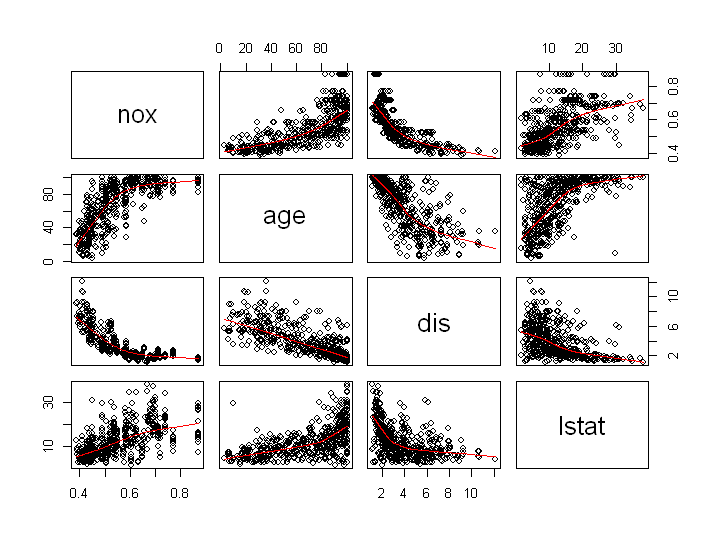

In [52]:
#b.
pairs(~nox+age+dis+lstat,Boston,panel=panel.smooth)

#nox x age: positive relationship (higher age, higher nox concentration), possibly exponential growth
#nox x dis: is negative relationship (higher distance, lower nox), possibly exponential decay
#nox x lstat: weak positive relationship (higher nox, higher lstat %), seems to be linear
#age x dis: negative relationship (higher age, lower distance), linear
#age x lstat: positive relationship (higher age, higher lstat), possibly log growth
#dis x lstat: negative relationship, possible exponential decay

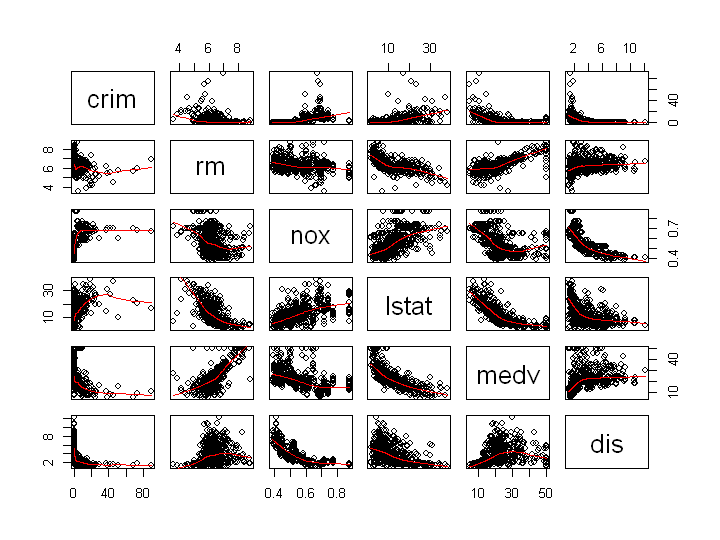

In [56]:
#c.
# more crime closer to employment centres, lower median house value, higher lstat, lower nox and rm
pairs(~crim+rm+nox+lstat+medv+dis,panel=panel.smooth,
      Boston)

      crim               tax           ptratio     
 Min.   : 0.00632   Min.   :187.0   Min.   :12.60  
 1st Qu.: 0.08204   1st Qu.:279.0   1st Qu.:17.40  
 Median : 0.25651   Median :330.0   Median :19.05  
 Mean   : 3.61352   Mean   :408.2   Mean   :18.46  
 3rd Qu.: 3.67708   3rd Qu.:666.0   3rd Qu.:20.20  
 Max.   :88.97620   Max.   :711.0   Max.   :22.00  

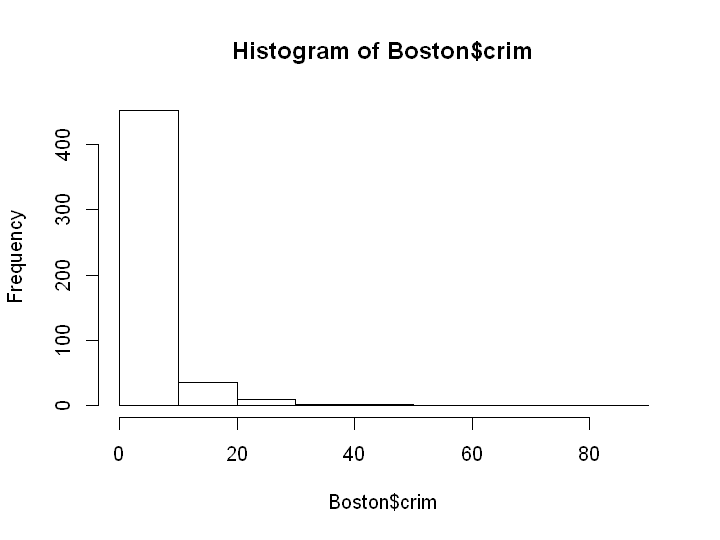

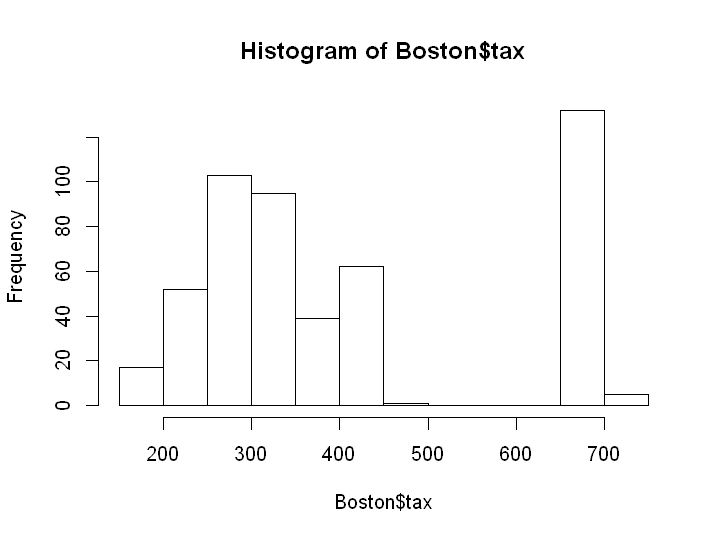

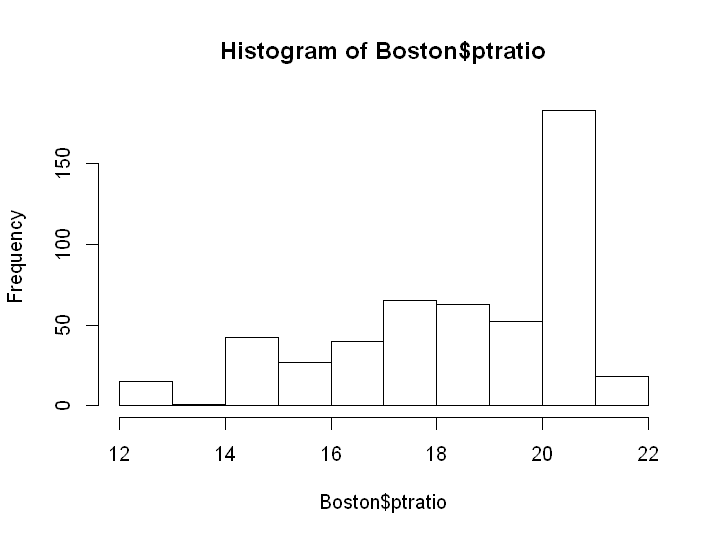

In [61]:
#d. particularly high crime rates:
summary(Boston[,c("crim", "tax", "ptratio")])

#Crim
hist(Boston$crim)
#Difference betweet 3rd quartile and max value shows outliers. This means there are subsurbs with a much higher crime rate

#Tax
hist(Boston$tax)
#Histogram shows a jump to very high tax rates (around 700)

#Ptratio
hist(Boston$ptratio)
# The ptratio has a range of ~10 (from 12.6 to 22) with a mean of ~18.5. 
#Suburbs with ratio over 20 may have a very high number of students per teacher.

In [75]:
#e. 35 suburbs
sum(Boston$chas)

#f. 19.05
median(Boston$ptratio)

#g.two suburbs with same median value of owner-occupied homes, same values for other predictors suggest same town
#no land zoned for lots, indus in 3rd quartile, not by river, over 3rd quartile nox, low number of rooms per dwelling,
#old suburbs as age is max value, dis close to minimum, rad and tax and ptratio in 3rd quartile, high black proportion,
#lstat close to max (high percentage of lower status population), medv corresponds to min
#seems to be working class suburbs
Boston[Boston$medv == min(Boston$medv),]

summary(Boston)

#h. 7 rooms: 64, 8: 13
summary(Boston$rm)

nrow(Boston[Boston$rm>7,])
nrow(Boston[Boston$rm>8,])

summary(Boston[Boston$rm>8,])

[1] 35

[1] 19.05

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
399,38.3518,0,18.1,0,0.693,5.453,100,1.4896,24,666,20.2,396.90,30.59,5
406,67.9208,0,18.1,0,0.693,5.683,100,1.4254,24,666,20.2,384.97,22.98,5


      crim                zn             indus            chas        
 Min.   : 0.00632   Min.   :  0.00   Min.   : 0.46   Min.   :0.00000  
 1st Qu.: 0.08204   1st Qu.:  0.00   1st Qu.: 5.19   1st Qu.:0.00000  
 Median : 0.25651   Median :  0.00   Median : 9.69   Median :0.00000  
 Mean   : 3.61352   Mean   : 11.36   Mean   :11.14   Mean   :0.06917  
 3rd Qu.: 3.67708   3rd Qu.: 12.50   3rd Qu.:18.10   3rd Qu.:0.00000  
 Max.   :88.97620   Max.   :100.00   Max.   :27.74   Max.   :1.00000  
      nox               rm             age              dis        
 Min.   :0.3850   Min.   :3.561   Min.   :  2.90   Min.   : 1.130  
 1st Qu.:0.4490   1st Qu.:5.886   1st Qu.: 45.02   1st Qu.: 2.100  
 Median :0.5380   Median :6.208   Median : 77.50   Median : 3.207  
 Mean   :0.5547   Mean   :6.285   Mean   : 68.57   Mean   : 3.795  
 3rd Qu.:0.6240   3rd Qu.:6.623   3rd Qu.: 94.08   3rd Qu.: 5.188  
 Max.   :0.8710   Max.   :8.780   Max.   :100.00   Max.   :12.127  
      rad              tax 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.561   5.886   6.208   6.285   6.623   8.780 

[1] 64

      crim               zn            indus             chas       
 Min.   :0.02009   Min.   : 0.00   Min.   : 2.680   Min.   :0.0000  
 1st Qu.:0.33147   1st Qu.: 0.00   1st Qu.: 3.970   1st Qu.:0.0000  
 Median :0.52014   Median : 0.00   Median : 6.200   Median :0.0000  
 Mean   :0.71879   Mean   :13.62   Mean   : 7.078   Mean   :0.1538  
 3rd Qu.:0.57834   3rd Qu.:20.00   3rd Qu.: 6.200   3rd Qu.:0.0000  
 Max.   :3.47428   Max.   :95.00   Max.   :19.580   Max.   :1.0000  
      nox               rm             age             dis       
 Min.   :0.4161   Min.   :8.034   Min.   : 8.40   Min.   :1.801  
 1st Qu.:0.5040   1st Qu.:8.247   1st Qu.:70.40   1st Qu.:2.288  
 Median :0.5070   Median :8.297   Median :78.30   Median :2.894  
 Mean   :0.5392   Mean   :8.349   Mean   :71.54   Mean   :3.430  
 3rd Qu.:0.6050   3rd Qu.:8.398   3rd Qu.:86.50   3rd Qu.:3.652  
 Max.   :0.7180   Max.   :8.780   Max.   :93.90   Max.   :8.907  
      rad              tax           ptratio          b

### Exercise 3 (p.120, Chap.3)

a. Correct answer is iii. For a fixed value of IQ and GPA, males earn more on average than females if GPA is >3.5 

b. 137.1

c. False, interaction term impact is measured in the unit of the coefficients. If the amount of GPA or IQ is high, the interaction effect (1% increase) results in a bigger impact as well

In [82]:
#calculations for previous answers
#Salary = B0 + B1*GPA + B2*IQ + B3*Gender_f + B4*(GPA*IQ) + B5*(GPA*Gender_f)
B0 <- 50
B1 <- 20
B2 <- 0.07
B3 <- 35
B4 <- 0.01
B5 <- -10

gender_f <- 1
iq <- 80
for (i in seq(1,4))
 {gpa <- i
    print(B0 + B1*gpa + B2*iq + B3*gender_f + B4*(gpa*iq) + B5*(gpa*gender_f))}

for (i in seq(1,4))
 {gpa <- i
    print(B0 + B1*gpa + B2*iq + B3*0 + B4*(gpa*iq) + B5*(gpa*0))}

#b
iq <- 110
gpa <- 4

salary <- B0 + B1*gpa + B2*iq + B3*gender_f + B4*(gpa*iq) + B5*(gpa*gender_f)
print(paste("F",salary))

gender_f <- 0
salary <- B0 + B1*gpa + B2*iq + B3*gender_f + B4*(gpa*iq) + B5*(gpa*gender_f)
print(paste("M",salary))

[1] 101.4
[1] 112.2
[1] 123
[1] 133.8
[1] 76.4
[1] 97.2
[1] 118
[1] 138.8
[1] "F 137.1"
[1] "M 142.1"


### Exercise 10 (p.123, Chap.3)

In [83]:
#a.
rm <- lm(Sales ~ Price + Urban + US, data = Carseats)
summary(rm)


Call:
lm(formula = Sales ~ Price + Urban + US, data = Carseats)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.9206 -1.6220 -0.0564  1.5786  7.0581 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 13.043469   0.651012  20.036  < 2e-16 ***
Price       -0.054459   0.005242 -10.389  < 2e-16 ***
UrbanYes    -0.021916   0.271650  -0.081    0.936    
USYes        1.200573   0.259042   4.635 4.86e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.472 on 396 degrees of freedom
Multiple R-squared:  0.2393,	Adjusted R-squared:  0.2335 
F-statistic: 41.52 on 3 and 396 DF,  p-value: < 2.2e-16


In [151]:
#b.
head(Carseats)

#B0 (Intercept): when all other coefficients are 0, the sales are 13.04
#B1 (Price): statistically significant (p-value < 0.05), the lower the price, the higher the sales
#B2 (UrbanYes): not significant (p-value > 0.05), higher sales in non-urban locations
#B3 (USYes): significant (p-value < 0.05), sales are higher in US stores

Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
11.22,111,48,16,260,83,Good,65,10,Yes,Yes
10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4.15,141,64,3,340,128,Bad,38,13,Yes,No
10.81,124,113,13,501,72,Bad,78,16,No,Yes


In [87]:
#c.
rm$coeff
#sales <- B0 + B1 * Price + B2 * UrbanYes + B3 * USYes #UrbanYes=1 and USYes=1


(Intercept)       Price    UrbanYes       USYes 
13.04346894 -0.05445885 -0.02191615  1.20057270


Call:
lm(formula = Sales ~ Price + US, data = Carseats)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.9269 -1.6286 -0.0574  1.5766  7.0515 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 13.03079    0.63098  20.652  < 2e-16 ***
Price       -0.05448    0.00523 -10.416  < 2e-16 ***
USYes        1.19964    0.25846   4.641 4.71e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.469 on 397 degrees of freedom
Multiple R-squared:  0.2393,	Adjusted R-squared:  0.2354 
F-statistic: 62.43 on 2 and 397 DF,  p-value: < 2.2e-16


,2.5 %,97.5 %
(Intercept),11.79032020,14.27126531
Price,-0.06475984,-0.04419543
USYes,0.69151957,1.70776632


     Sales            Price         US     
 Min.   : 0.000   Min.   : 24.0   No :142  
 1st Qu.: 5.390   1st Qu.:100.0   Yes:258  
 Median : 7.490   Median :117.0            
 Mean   : 7.496   Mean   :115.8            
 3rd Qu.: 9.320   3rd Qu.:131.0            
 Max.   :16.270   Max.   :191.0            

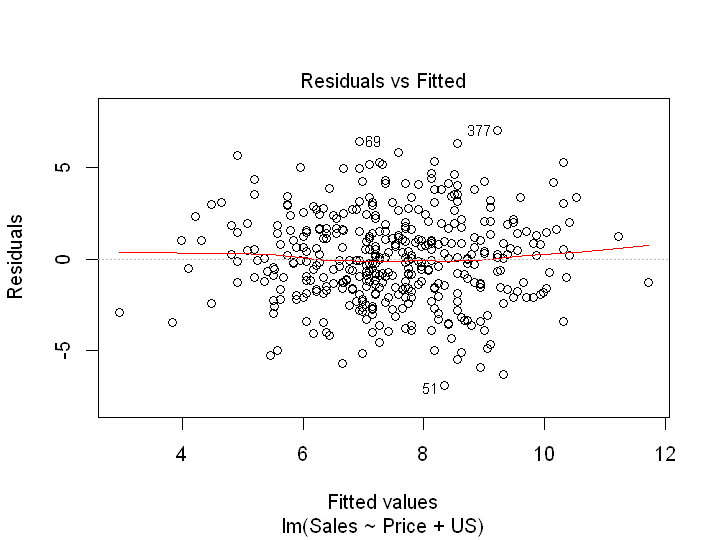

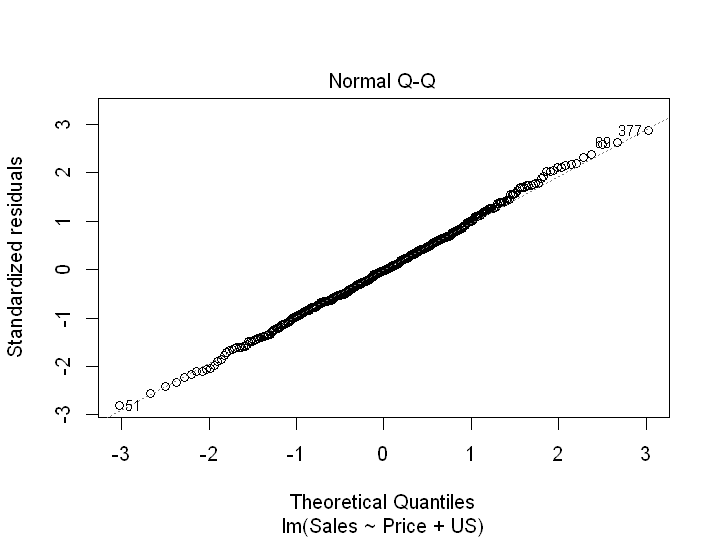

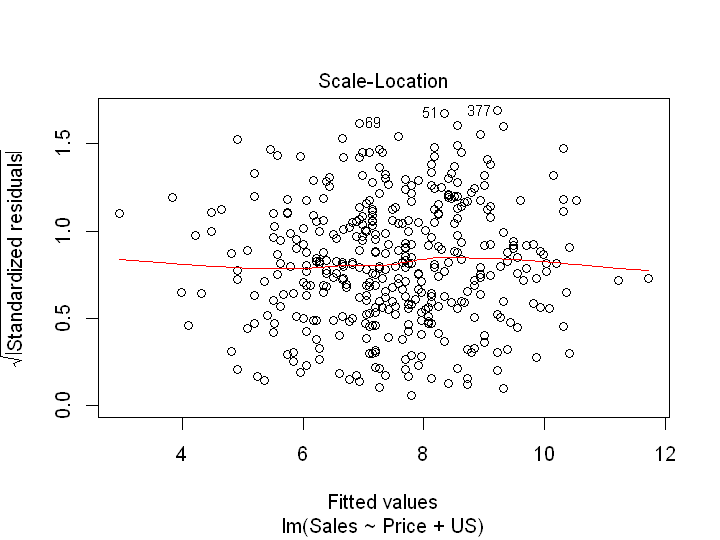

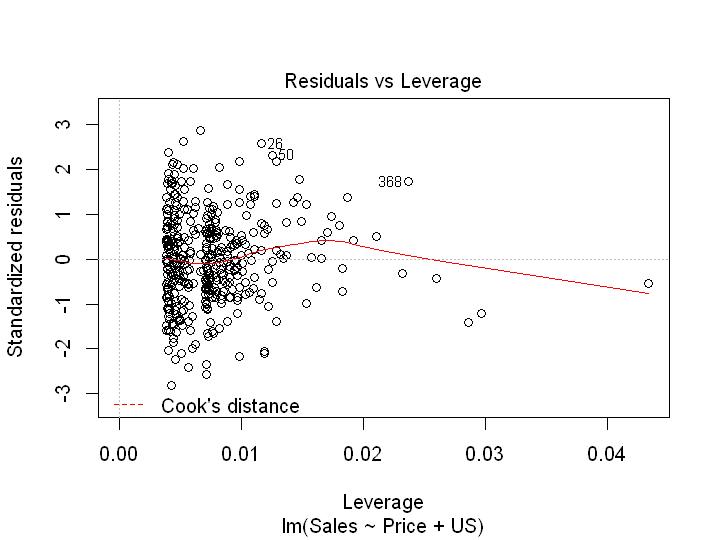

In [91]:
#d.
#UrbanYes has a p-value of 0.936 > 0.05, so it is not statistically significant with a 95% confidence level and can be rejected

#e.
lm.fit_sig <- lm(Sales ~ Price + US, data = Carseats)
summary(lm.fit_sig)

#f.
#Adj R2 for the first model is 0.2335 and for the second model it is 0.2354
#Therefore, both models only explain around 23% of the total variance for sales

#g.
confint(lm.fit1, level = 0.95) #or: Betas +- 2*SE

#h.
summary(Carseats[,c("Sales", "Price", "US")])
plot(lm.fit_sig)
#there is no clear evidence for outliers or high leverage observations

In [111]:
#Exercise 15 (p.126, Chap.3)

#a.All coefficients are significant on a simple linear regression model
simple <- c()
for (coeff in names(Boston)){
    lm.fit <- lm(Boston$crim ~ Boston[,coeff])
    if (summary(lm.fit)$coefficients[2,4]<0.05)
    {print(paste(coeff,"statistically significant"))}}


Warning message in summary.lm(lm.fit):
"essentially perfect fit: summary may be unreliable"

[1] "crim statistically significant"
[1] "zn statistically significant"
[1] "indus statistically significant"
[1] "nox statistically significant"
[1] "rm statistically significant"
[1] "age statistically significant"
[1] "dis statistically significant"
[1] "rad statistically significant"
[1] "tax statistically significant"
[1] "ptratio statistically significant"
[1] "black statistically significant"
[1] "lstat statistically significant"
[1] "medv statistically significant"


(Intercept)           zn          dis          rad        black         medv 
1.894909e-02 1.702489e-02 5.022039e-04 6.460451e-11 4.070233e-02 1.086810e-03


Call:
lm(formula = crim ~ ., data = Boston)

Residuals:
   Min     1Q Median     3Q    Max 
-9.924 -2.120 -0.353  1.019 75.051 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  17.033228   7.234903   2.354 0.018949 *  
zn            0.044855   0.018734   2.394 0.017025 *  
indus        -0.063855   0.083407  -0.766 0.444294    
chas         -0.749134   1.180147  -0.635 0.525867    
nox         -10.313535   5.275536  -1.955 0.051152 .  
rm            0.430131   0.612830   0.702 0.483089    
age           0.001452   0.017925   0.081 0.935488    
dis          -0.987176   0.281817  -3.503 0.000502 ***
rad           0.588209   0.088049   6.680 6.46e-11 ***
tax          -0.003780   0.005156  -0.733 0.463793    
ptratio      -0.271081   0.186450  -1.454 0.146611    
black        -0.007538   0.003673  -2.052 0.040702 *  
lstat         0.126211   0.075725   1.667 0.096208 .  
medv         -0.198887   0.060516  -3.287 0.001087 ** 
---
Signif. codes:  0 '***' 0.0


Call:
lm(formula = crim ~ zn + dis + rad + black + medv, data = Boston)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.553  -1.869  -0.358   0.839  75.744 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.919933   1.778986   4.452 1.05e-05 ***
zn           0.051799   0.017329   2.989 0.002935 ** 
dis         -0.672189   0.202939  -3.312 0.000992 ***
rad          0.472306   0.042102  11.218  < 2e-16 ***
black       -0.008211   0.003615  -2.271 0.023562 *  
medv        -0.174219   0.036295  -4.800 2.10e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.473 on 500 degrees of freedom
Multiple R-squared:  0.4393,	Adjusted R-squared:  0.4337 
F-statistic: 78.34 on 5 and 500 DF,  p-value: < 2.2e-16


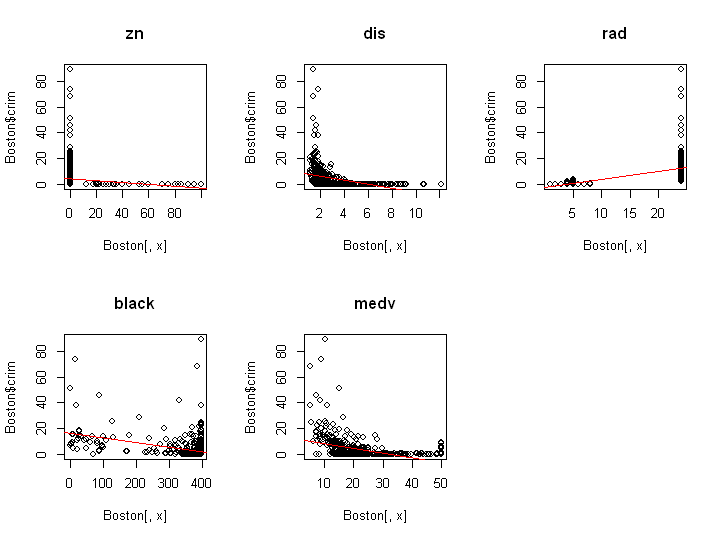

In [146]:
#b. Only predictors with a p-value > 0.05 are significant and null hypothesis can be rejected
lm.fit <- lm(crim ~., data = Boston)
pvalue <- summary(lm.fit)$coefficients[,4]
pvalue <- pvalue[pvalue<0.05]
pvalue

summary(lm.fit)

pvaluefit <- lm(crim~zn+dis+rad+black+medv,data=Boston)
summary(pvaluefit)
#plot(pvaluefit)

par( mfrow = c(2,3) )
for (x in names(pvalue)[2:length(pvalue)]){
    plot(Boston[,x], Boston$crim, main=x)
    abline(lm(Boston$crim ~ Boston[,x]), col='red')
}



,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
Estimate,-7.393498e-02,5.097763e-01,-1.8927766,3.124853e+01,-2.684051e+00,1.077862e-01,-1.550902e+00,6.179109e-01,2.974225e-02,1.151983e+00,-3.627964e-02,5.488048e-01,-3.631599e-01
Std. Error,1.609460e-02,5.102433e-02,1.5061155,2.999190e+00,5.320411e-01,1.273644e-02,1.683300e-01,3.433182e-02,1.847415e-03,1.693736e-01,3.873154e-03,4.776097e-02,3.839017e-02
t value,-4.593776e+00,9.990848e+00,-1.2567274,1.041899e+01,-5.044819e+00,8.462825e+00,-9.213458e+00,1.799820e+01,1.609939e+01,6.801430e+00,-9.366951e+00,1.149065e+01,-9.459710e+00
Pr(>|t|),5.506472e-06,1.450349e-21,0.2094345,3.751739e-23,6.346703e-07,2.854869e-16,8.519949e-19,2.693844e-56,2.357127e-47,2.942922e-11,2.487274e-19,2.654277e-27,1.173987e-19


,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
Estimate,0.04485521,-0.06385482,-0.7491336,-10.313535,0.4301305,0.001451643,-0.9871757255,5.882086e-01,-0.003780016,-0.2710806,-0.007537505,0.12621138,-0.19888682
Std. Error,0.01873407,0.08340724,1.1801468,5.275536,0.6128303,0.017925128,0.2818172658,8.804927e-02,0.005155587,0.1864505,0.003673322,0.07572484,0.06051599
t value,2.39431224,-0.76557890,-0.6347800,-1.954974,0.7018754,0.080983715,-3.5028929925,6.680448e+00,-0.733188384,-1.4539010,-2.051958926,1.66671043,-3.28651687
Pr(>|t|),0.01702489,0.44429400,0.5258670,0.051152,0.4830888,0.935487835,0.0005022039,6.460451e-11,0.463792728,0.1466113,0.040702332,0.09620842,0.00108681


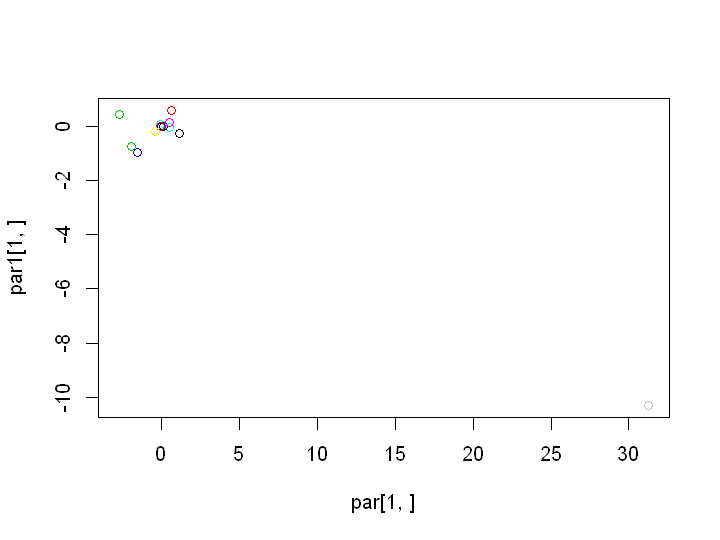

In [145]:
#c.
library(tidyr)

#multiple: pvaluefit
par1 <- t(sum1)
par1 <- par1[,2:ncol(par1)]
par <- sum[,2:ncol(sum)]

par
par1

plot(par[1,], par1[1,], col=factor(colnames(par)))

#d. The plots from do not show a simple linear relationship between response and predictor variables
# predictor variables "rad" and "black"